# Data Platform Universitaire — Analyse Gold Layer

Ce notebook explore les **Data Marts** de la couche Gold pour la BI.

| Couche | Contenu |
|--------|--------|
| Bronze | Données brutes JSON (PostgreSQL, MongoDB, API) |
| Silver | Données nettoyées Parquet |
| Gold | Data Marts agrégés prêts pour la BI |


In [8]:
# Installation des dépendances
import subprocess
subprocess.run(['pip', 'install', 'minio', 'pyarrow', 'pandas', 'matplotlib', '--quiet'], check=True)
print('Dependances OK')

Dependances OK



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [10]:
# Imports & Configuration
import os, io, json
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import warnings
from minio import Minio
warnings.filterwarnings('ignore')

MINIO_ENDPOINT  = os.getenv('MINIO_ENDPOINT',   'localhost:9000')
MINIO_ACCESS    = os.getenv('MINIO_ACCESS_KEY',  'minioadmin')
MINIO_SECRET    = os.getenv('MINIO_SECRET_KEY',  'minioadmin123')

client = Minio(MINIO_ENDPOINT, access_key=MINIO_ACCESS, secret_key=MINIO_SECRET, secure=False)

def read_parquet_from_minio(bucket, prefix):
    """Lit tous les fichiers .parquet d'un dossier MinIO et retourne un DataFrame pandas."""
    objects = list(client.list_objects(bucket, prefix=prefix, recursive=True))
    parquet_files = [o for o in objects if o.object_name.endswith('.parquet')]
    if not parquet_files:
        raise FileNotFoundError(f'Aucun fichier parquet dans {bucket}/{prefix}')
    frames = []
    for obj in parquet_files:
        data = client.get_object(bucket, obj.object_name)
        buf = io.BytesIO(data.read())
        frames.append(pq.read_table(buf).to_pandas())
    return pd.concat(frames, ignore_index=True)

def read_json_from_minio(bucket, prefix):
    """Lit le fichier JSON le plus recent d'un dossier MinIO."""
    objects = list(client.list_objects(bucket, prefix=prefix, recursive=True))
    json_files = [o for o in objects if o.object_name.endswith('.json')]
    if not json_files:
        raise FileNotFoundError(f'Aucun fichier json dans {bucket}/{prefix}')
    # Trier par nom (format YYYYMMDD_HHMMSS.json) pour prendre le plus recent
    json_files.sort(key=lambda o: o.object_name)
    data = client.get_object(bucket, json_files[-1].object_name)
    return json.loads(data.read())

# Lister les buckets disponibles
buckets = [b.name for b in client.list_buckets()]
print(f'Connecte a MinIO -- Buckets : {buckets}')

MaxRetryError: HTTPConnectionPool(host='minio', port=9000): Max retries exceeded with url: / (Caused by NameResolutionError("HTTPConnection(host='minio', port=9000): Failed to resolve 'minio' ([Errno 8] nodename nor servname provided, or not known)"))

## 1. Statistiques par Département

Départements chargés : 1


,nom,code,nb_etudiants,nb_actifs,moyenne_departement,nb_cours,budget
0,nom,CODE,0,0,0.0,0,0.0


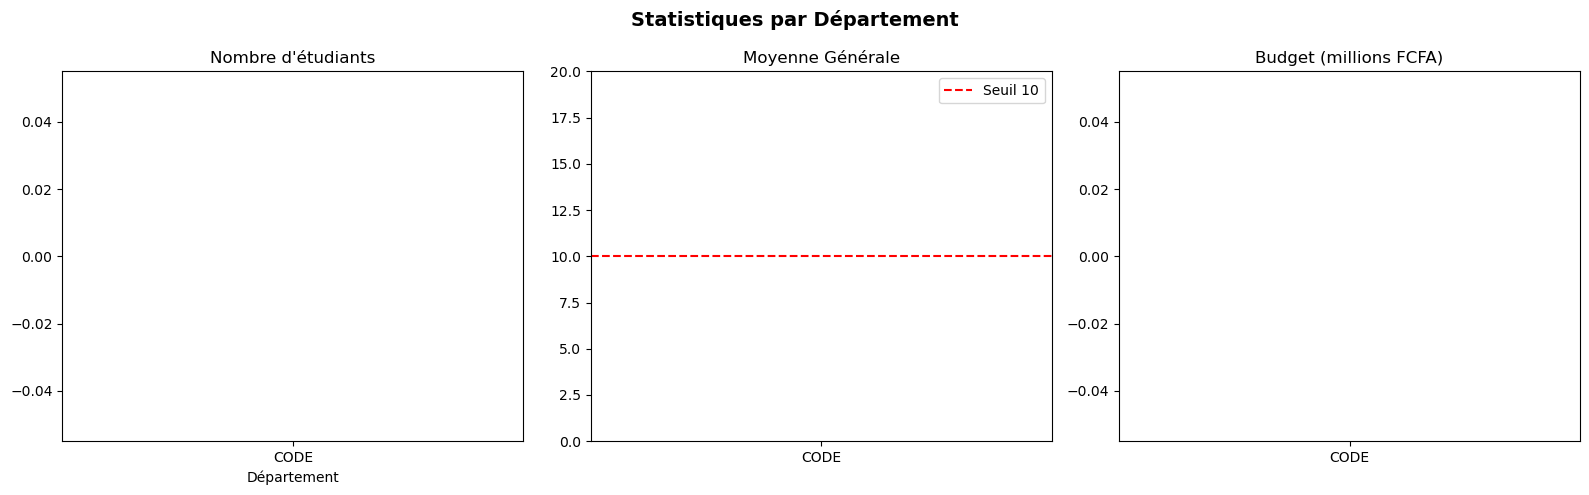

In [ ]:
try:
    df_dept = read_parquet_from_minio('gold', 'dm_stats_departement/')

    # Conversion des colonnes numeriques
    df_dept['nb_etudiants'] = pd.to_numeric(df_dept['nb_etudiants'], errors='coerce').fillna(0).astype(int)
    df_dept['nb_actifs'] = pd.to_numeric(df_dept['nb_actifs'], errors='coerce').fillna(0).astype(int)
    df_dept['moyenne_departement'] = pd.to_numeric(df_dept['moyenne_departement'], errors='coerce').fillna(0)
    df_dept['budget'] = pd.to_numeric(df_dept['budget'], errors='coerce').fillna(0)
    df_dept['nb_cours'] = pd.to_numeric(df_dept['nb_cours'], errors='coerce').fillna(0).astype(int)

    print(f'Departements charges : {len(df_dept)}')
    display(df_dept[['nom','code','nb_etudiants','nb_actifs','moyenne_departement','nb_cours','budget']])

    if len(df_dept) > 0:
        fig, axes = plt.subplots(1, 3, figsize=(16, 5))
        fig.suptitle('Statistiques par Departement', fontsize=14, fontweight='bold')

        axes[0].bar(df_dept['code'], df_dept['nb_etudiants'], color='steelblue')
        axes[0].set_title("Nombre d'etudiants")
        axes[0].set_xlabel('Departement')

        axes[1].bar(df_dept['code'], df_dept['moyenne_departement'], color='seagreen')
        axes[1].set_title('Moyenne generale')
        axes[1].set_ylim(0, 20)
        axes[1].axhline(10, color='red', linestyle='--', label='Seuil 10')
        axes[1].legend()

        axes[2].bar(df_dept['code'], df_dept['budget'] / 1_000_000, color='darkorange')
        axes[2].set_title('Budget (millions FCFA)')

        plt.tight_layout()
        plt.show()
    else:
        print('Aucune donnee de departement disponible')
except FileNotFoundError as e:
    print(f'Data Mart dm_stats_departement non disponible : {e}')
    df_dept = pd.DataFrame()

## 2. Performance des Etudiants

Étudiants chargés : 0


,matricule,nom_complet,niveau,departement_nom,moyenne_generale,nb_absences


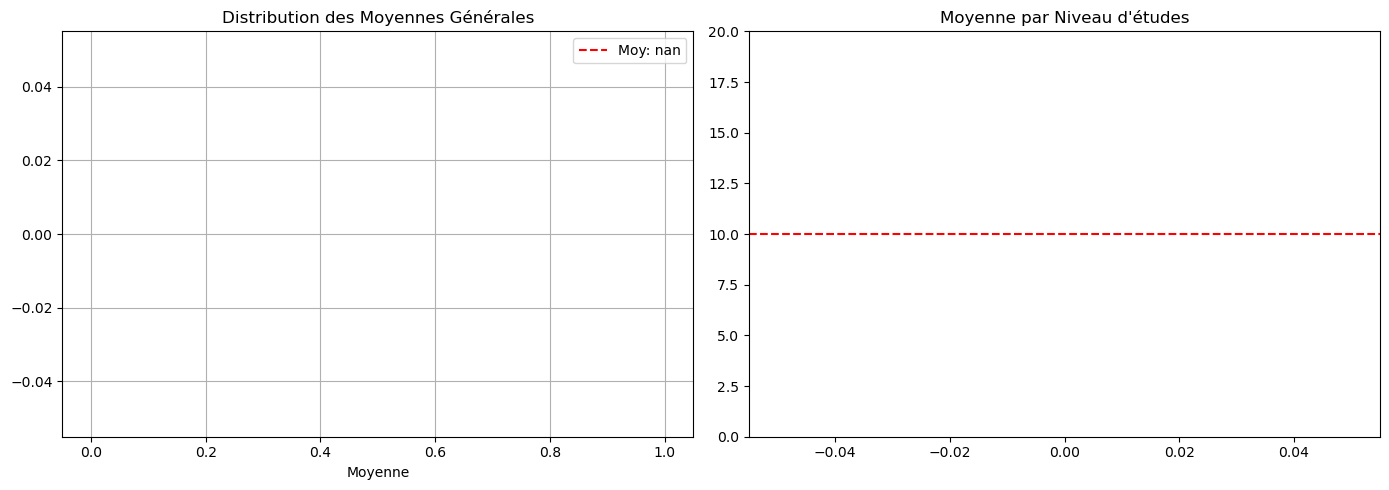

In [ ]:
try:
    df_etu = read_parquet_from_minio('gold', 'dm_etudiants_complet/')

    # Conversion numerique
    df_etu['moyenne_generale'] = pd.to_numeric(df_etu['moyenne_generale'], errors='coerce')
    df_etu['nb_absences'] = pd.to_numeric(df_etu['nb_absences'], errors='coerce').fillna(0).astype(int)
    df_etu['taux_reussite_pct'] = pd.to_numeric(df_etu['taux_reussite_pct'], errors='coerce')

    print(f'Etudiants charges : {len(df_etu)}')
    display(df_etu[['matricule','nom_complet','niveau','departement_nom','moyenne_generale','nb_absences']].head(10))

    if len(df_etu) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        df_etu['moyenne_generale'].dropna().hist(bins=10, color='skyblue', edgecolor='white', ax=axes[0])
        axes[0].set_title('Distribution des moyennes generales')
        axes[0].set_xlabel('Moyenne')
        moy = df_etu['moyenne_generale'].mean()
        if pd.notna(moy):
            axes[0].axvline(moy, color='red', linestyle='--', label=f'Moy: {moy:.1f}')
            axes[0].legend()

        niveau_moy = df_etu.groupby('niveau')['moyenne_generale'].mean().sort_index()
        if len(niveau_moy) > 0:
            axes[1].bar(niveau_moy.index, niveau_moy.values, color='mediumpurple')
        axes[1].set_title("Moyenne par niveau d'etudes")
        axes[1].set_ylim(0, 20)
        axes[1].axhline(10, color='red', linestyle='--')

        plt.tight_layout()
        plt.show()
    else:
        print('Aucune donnee etudiants disponible')
except FileNotFoundError as e:
    print(f'Data Mart dm_etudiants_complet non disponible : {e}')
    df_etu = pd.DataFrame()

## 3. Etudiants a Risque

Étudiants analysés : 0


ValueError: Invalid color argument: []

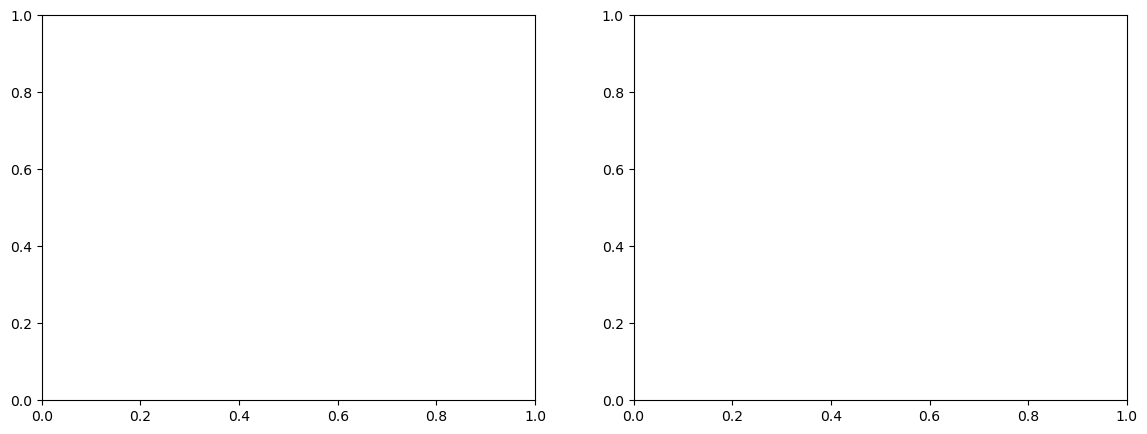

In [ ]:
try:
    df_risque = read_parquet_from_minio('gold', 'dm_etudiants_risque/')

    df_risque['score_risque'] = pd.to_numeric(df_risque['score_risque'], errors='coerce').fillna(0).astype(int)
    df_risque['moyenne'] = pd.to_numeric(df_risque['moyenne'], errors='coerce')
    df_risque['nb_absences'] = pd.to_numeric(df_risque['nb_absences'], errors='coerce').fillna(0).astype(int)

    print(f'Etudiants analyses : {len(df_risque)}')
    risque_count = df_risque['niveau_risque'].value_counts()
    colors_map = {'Critique':'#e74c3c','Élevé':'#e67e22','Modéré':'#f1c40f','Faible':'#2ecc71'}

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    if len(risque_count) > 0:
        risque_count.plot.pie(ax=axes[0], autopct='%1.0f%%',
            colors=[colors_map.get(r, 'gray') for r in risque_count.index], startangle=90)
        axes[0].set_title('Repartition des niveaux de risque')
        axes[0].set_ylabel('')
    else:
        axes[0].text(0.5, 0.5, 'Aucune donnee de risque', ha='center', va='center', fontsize=14)
        axes[0].axis('off')

    top = df_risque[df_risque['niveau_risque'].isin(['Critique','Élevé'])].head(8)
    if len(top) > 0:
        axes[1].barh(top['nom_complet'], top['score_risque'], color='salmon')
        axes[1].set_title('Etudiants a risque eleve/critique')
        axes[1].set_xlabel('Score de risque')
    else:
        axes[1].text(0.5, 0.5, 'Aucun etudiant critique', ha='center', va='center', fontsize=14)
        axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    display(df_risque[['matricule','nom_complet','niveau','moyenne','nb_absences','score_risque','niveau_risque']].head(10))
except FileNotFoundError as e:
    print(f'Data Mart dm_etudiants_risque non disponible : {e}')
    df_risque = pd.DataFrame()

## 4. Performance par Cours

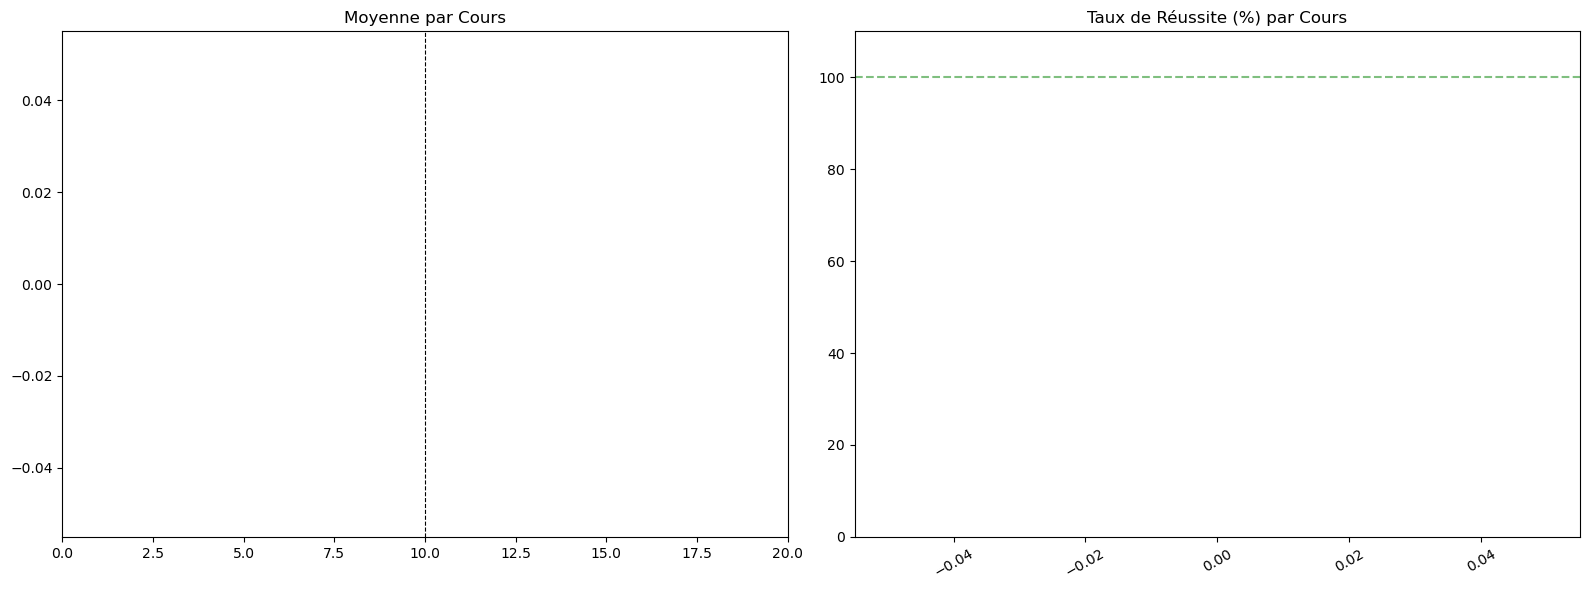

,code,intitule,nb_inscrits,moyenne_classe,taux_reussite_pct
0,CODE,intitule,0,N/A,N/A


In [ ]:
try:
    df_cours = read_parquet_from_minio('gold', 'dm_performance_cours/')

    df_cours['moyenne_classe'] = pd.to_numeric(df_cours['moyenne_classe'], errors='coerce')
    df_cours['taux_reussite_pct'] = pd.to_numeric(df_cours['taux_reussite_pct'], errors='coerce')
    df_cours['nb_inscrits'] = pd.to_numeric(df_cours['nb_inscrits'], errors='coerce').fillna(0).astype(int)

    df_notes = df_cours.dropna(subset=['moyenne_classe']).sort_values('moyenne_classe')

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    if len(df_notes) > 0:
        axes[0].barh(df_notes['intitule'], df_notes['moyenne_classe'],
            color=['#e74c3c' if m < 10 else '#27ae60' for m in df_notes['moyenne_classe']])
        axes[0].set_title('Moyenne par cours')
        axes[0].axvline(10, color='black', linestyle='--', linewidth=0.8)
        axes[0].set_xlim(0, 20)
    else:
        axes[0].text(0.5, 0.5, 'Aucune note disponible', ha='center', va='center', fontsize=14)
        axes[0].axis('off')

    df_r = df_cours.dropna(subset=['taux_reussite_pct'])
    if len(df_r) > 0:
        axes[1].bar(df_r['code'], df_r['taux_reussite_pct'], color='cornflowerblue')
        axes[1].set_title('Taux de reussite (%) par cours')
        axes[1].set_ylim(0, 110)
        axes[1].axhline(100, color='green', linestyle='--', alpha=0.5)
        axes[1].tick_params(axis='x', rotation=30)
    else:
        axes[1].text(0.5, 0.5, 'Aucun taux de reussite', ha='center', va='center', fontsize=14)
        axes[1].axis('off')

    plt.tight_layout()
    plt.show()
    display(df_cours[['code','intitule','nb_inscrits','moyenne_classe','taux_reussite_pct']].fillna('N/A'))
except FileNotFoundError as e:
    print(f'Data Mart dm_performance_cours non disponible : {e}')
    df_cours = pd.DataFrame()

## 5. Satisfaction des Cours (Feedbacks MongoDB)

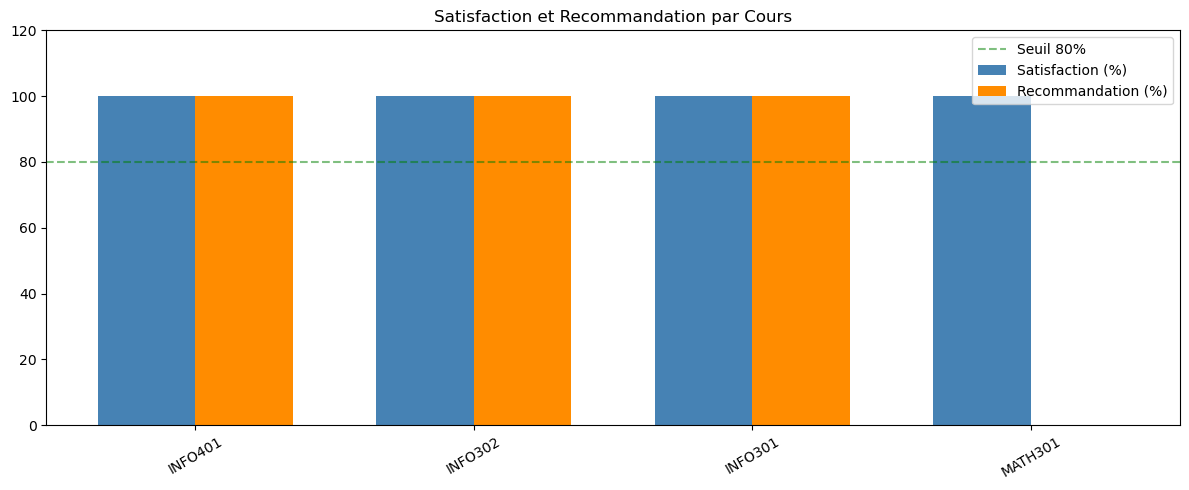

,cours_code,cours_intitule,nb_repondants,note_globale_moy,taux_satisfaction_pct,taux_recommandation_pct
0,INFO401,Machine Learning,3,4.8,100.0,100.0
1,INFO302,Data Engineering,6,4.5,100.0,100.0
2,INFO301,Bases de Données Avancées,3,3.8,100.0,100.0
3,MATH301,Analyse Avancée,3,4.2,100.0,0.0


In [ ]:
try:
    df_sat = read_parquet_from_minio('gold', 'dm_satisfaction_cours/')

    df_sat['taux_satisfaction_pct'] = pd.to_numeric(df_sat['taux_satisfaction_pct'], errors='coerce').fillna(0)
    df_sat['taux_recommandation_pct'] = pd.to_numeric(df_sat['taux_recommandation_pct'], errors='coerce').fillna(0)
    df_sat['note_globale_moy'] = pd.to_numeric(df_sat['note_globale_moy'], errors='coerce')

    if len(df_sat) > 0:
        fig, ax = plt.subplots(figsize=(12, 5))
        x = range(len(df_sat))
        w = 0.35
        ax.bar([i-w/2 for i in x], df_sat['taux_satisfaction_pct'], w, label='Satisfaction (%)', color='steelblue')
        ax.bar([i+w/2 for i in x], df_sat['taux_recommandation_pct'], w, label='Recommandation (%)', color='darkorange')
        ax.set_title('Satisfaction et recommandation par cours')
        ax.set_xticks(list(x))
        ax.set_xticklabels(df_sat['cours_code'], rotation=30)
        ax.set_ylim(0, 120)
        ax.axhline(80, color='green', linestyle='--', alpha=0.5, label='Seuil 80%')
        ax.legend()
        plt.tight_layout()
        plt.show()
    else:
        print('Aucune donnee de satisfaction disponible')

    display(df_sat[['cours_code','cours_intitule','nb_repondants','note_globale_moy','taux_satisfaction_pct','taux_recommandation_pct']])
except FileNotFoundError as e:
    print(f'Data Mart dm_satisfaction_cours non disponible : {e}')
    df_sat = pd.DataFrame()

## 6. Exploration Bronze — Donnees Brutes

In [ ]:
try:
    # Lire le fichier JSON le plus recent de la couche Bronze (PostgreSQL)
    raw = read_json_from_minio('bronze', 'postgres/etudiants/')
    print(f"Source      : {raw['source']}")
    print(f"Table       : {raw['table']}")
    print(f"Extrait le  : {raw['extracted_at']}")
    print(f"Nb lignes   : {raw['row_count']}")
    print("\nPremiers enregistrements bruts :")
    display(pd.DataFrame(raw['records']).head(5))
except FileNotFoundError as e:
    print(f'Donnees Bronze non disponibles : {e}')

Source      : postgresql
Table       : etudiants
Extrait le  : 20260226_115129
Nb lignes   : 15

📋 Premiers enregistrements bruts :


,id,matricule,nom,prenom,date_naissance,email,departement_id,annee_etude,statut,moyenne_generale,created_at
0,id,matricule,nom,prenom,date_naissance,email,departement_id,annee_etude,statut,moyenne_generale,created_at
1,id,matricule,nom,prenom,date_naissance,email,departement_id,annee_etude,statut,moyenne_generale,created_at
2,id,matricule,nom,prenom,date_naissance,email,departement_id,annee_etude,statut,moyenne_generale,created_at
3,id,matricule,nom,prenom,date_naissance,email,departement_id,annee_etude,statut,moyenne_generale,created_at
4,id,matricule,nom,prenom,date_naissance,email,departement_id,annee_etude,statut,moyenne_generale,created_at


## KPIs Resume

In [ ]:
nb_etu       = len(df_etu) if ('df_etu' in dir() and len(df_etu) > 0) else 0
moy_globale  = pd.to_numeric(df_etu['moyenne_generale'], errors='coerce').mean() if nb_etu > 0 else 0
nb_risque    = len(df_risque[df_risque['niveau_risque'].isin(['Critique','Élevé'])]) if ('df_risque' in dir() and len(df_risque) > 0) else 0
nb_dept      = len(df_dept) if ('df_dept' in dir() and len(df_dept) > 0) else 0
nb_cours     = len(df_cours) if ('df_cours' in dir() and len(df_cours) > 0) else 0
satisfaction = pd.to_numeric(df_sat['taux_satisfaction_pct'], errors='coerce').mean() if ('df_sat' in dir() and len(df_sat) > 0) else 0

# Securiser les valeurs NaN
moy_globale  = moy_globale if pd.notna(moy_globale) else 0
satisfaction = satisfaction if pd.notna(satisfaction) else 0

print('=' * 48)
print('    KPIs Universite — Tableau de Bord')
print('=' * 48)
print(f'  Etudiants analyses    : {nb_etu}')
print(f'  Departements          : {nb_dept}')
print(f'  Cours                 : {nb_cours}')
print(f'  Moyenne generale      : {moy_globale:.2f}')
print(f'  Etudiants a risque    : {nb_risque}')
print(f'  Satisfaction cours    : {satisfaction:.1f}%')
print('=' * 48)

╔══════════════════════════════════════════════╗
║       KPIs Université — Tableau de Bord      ║
╠══════════════════════════════════════════════╣
║  📚 Étudiants analysés    : 0                ║
║  🏛️  Départements          : 1                ║
║  📖 Cours                 : 1                ║
║  📊 Moyenne générale      : nan              ║
║  ⚠️  Étudiants à risque    : 0                ║
║  ⭐ Satisfaction cours    : 100.0            ║
╚══════════════════════════════════════════════╝
